In [1]:
import numpy as np
import pandas as pd
import numpy.linalg as la
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import train_test_split

In [2]:
rs = 1729

In [3]:
original_df = pd.read_csv(r'../datasets/aug_train.csv')
original_df = original_df.loc[:, ~original_df.columns.isin(['id'])]
original_df.head()


,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,Male,22,1,7.0,1,< 1 Year,No,2630.0,152.0,16,0
1,Male,42,1,28.0,0,1-2 Year,Yes,43327.0,26.0,135,0
2,Female,66,1,33.0,0,1-2 Year,Yes,35841.0,124.0,253,0
3,Female,22,1,33.0,0,< 1 Year,No,27645.0,152.0,69,0
4,Male,28,1,46.0,1,< 1 Year,No,29023.0,152.0,211,0


In [4]:
def to_numpy(df, preds, trgts, encs=None):
    columns = list(df.columns)
    X = np.empty(df[[i for k, v in preds.items() for i in v]].shape)
    Y = np.empty(df[[i for k, v in trgts.items() for i in v]].shape)

    for i, col in enumerate(preds['continuous']):
        X[:, columns.index(col)] = df[col]
    for i, col in enumerate(trgts['continuous']):
        Y[:, i] = df[col]

    if encs is None:
        encs = dict()
    for i, col in enumerate(preds['categorical']):
        if col not in encs:
            enc = LabelEncoder()
            enc.fit(df[col])
            encs[col] = enc
        else:
            enc = encs[col]
        X[:, columns.index(col)] = enc.transform(df[col])
    for i, col in enumerate(trgts['categorical']):
        if col not in encs:
            enc = LabelEncoder()
            enc.fit(df[col])
            encs[col] = enc
        else:
            enc = encs[col]
        Y[:, i] = enc.transform(df[col])

    return X, Y, encs



In [5]:
import joblib


predictors = {'categorical': ['Gender', 'Age', 'Driving_License',
                                  'Region_Code', 'Previously_Insured', 'Vehicle_Age',
                                  'Vehicle_Damage', 'Policy_Sales_Channel', 'Vintage'],
              'continuous': ['Annual_Premium']}
targets = {'categorical': ['Response'],
           'continuous': []}
pre_process_model = joblib.load(r"../model/logistic_regression_pre_process.pkl")
original_df = original_df[pre_process_model['columns']]
_X, _Y, _encs = to_numpy(original_df,
                         preds=predictors,
                         trgts=targets,
                         encs=pre_process_model["encs"])
joined = np.hstack((_X, _Y))

/Users/Vishvig/Desktop/Education/UoB/.uob/envs/data_analytics/lib/python3.9/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator LabelEncoder from version 1.1.1 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [6]:
n_samples, n_features = original_df.shape

features = list()
features.extend(predictors['continuous'])
features.extend(targets['continuous'])

X = np.zeros((n_samples, len(features)))
columns = list(pre_process_model['columns'])

for i, feature in enumerate(features):
    X[:, i] = joined[:, columns.index(feature)]
print(X[0:20])

[[ 2630.]
 [43327.]
 [35841.]
 [27645.]
 [29023.]
 [27954.]
 [ 2630.]
 [ 2630.]
 [55873.]
 [27801.]
 [63623.]
 [47665.]
 [25434.]
 [40044.]
 [38347.]
 [33303.]
 [ 2630.]
 [30649.]
 [35887.]
 [28333.]]


In [8]:
import warnings
from sklearn.exceptions import ConvergenceWarning
from sklearn.model_selection import KFold


def cross_validation(model, X, cv=5):
    train_scores = list()
    val_scores = list()
    _cv = KFold(n_splits=cv,random_state=rs, shuffle=True)
    with warnings.catch_warnings():
        warnings.filterwarnings('error', category=ConvergenceWarning)
        try:
            for train_index, val_index in _cv.split(X):
                Xtrain, Xval = X[train_index], X[val_index]
                model.fit(Xtrain)
                train_scores.append(np.sum(-model.score_samples(Xtrain)) / Xtrain.shape[0])
                val_scores.append(np.sum(-model.score_samples(Xval)) / Xval.shape[0])
        except ValueError as e:
            raise ValueError(e)
        except ConvergenceWarning as e:
            raise ConvergenceWarning(e)
    return {'train_score': train_scores, 'test_score': val_scores}


def train(**kwargs):
    trainNLL = []
    validNLL = []
    nvalid = []
    valid_max_iter = None
    valid_reg_covar = None
    
    max_iters = kwargs.get('max_iters', None)
    reg_covars = kwargs.get('reg_covars', None)
    nvals = kwargs.get('nvals', None)
    cov_types = kwargs.get('cov_types', None)
    
    if max_iters is None:
        max_iters = [10, 100, 1000, 10000, 100000]
    if reg_covars is None:
        reg_covars = [1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1]
    if nvals is None:
        nvals = (1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 20, 30, 40 , 50)
    if cov_types is None:
        cov_types = ['full', 'spherical', 'diag', 'tied']
    
    with warnings.catch_warnings():
        warnings.filterwarnings('error', category=ConvergenceWarning)
        for reg_covar in reg_covars:
            if valid_reg_covar is None:
                valid_reg_covar = reg_covar
            else:
                print(f"valid reg_covar from training: {valid_reg_covar}")
                break
            print(f"Trying reg_covar: {reg_covar}")
            for max_iter in max_iters:
                if valid_max_iter is None:
                    valid_max_iter = max_iter
                else:
                    if valid_reg_covar is None:
                        continue
                    if len(nvalid) > 0:
                        print(f"valid max_iter from training: {valid_max_iter}")
                        break
                print(f"Trying max_iter: {max_iter}")
                for i, cov in enumerate(cov_types):
                    if valid_max_iter is None or valid_reg_covar is None:
                        break
                    for j, n in enumerate(nvals):
                        if valid_max_iter is None or valid_reg_covar is None:
                            break
                        print(f"{i}-{j}")
                        train_score = None
                        validation_score = None
                        try:
                            model = GaussianMixture(n_components=n,
                                                    covariance_type=cov,
                                                    random_state = rs,
                                                    max_iter=valid_max_iter,
                                                    reg_covar=valid_reg_covar
                                                   )
                            scores = cross_validation(model, X, cv=5)
                            trainNLL.append(np.mean(scores['train_score']))
                            validNLL.append(np.mean(scores['test_score']))
                            nvalid.append(f"{i}-{j}")
                        except ValueError as e:
                            warnings.warn(f"reg_covar {reg_covar} is too small.")
                            valid_reg_covar = None
                            valid_max_iter = None
                            trainNLL = []
                            validNLL = []
                            nvalid = []
                            break
                        except ConvergenceWarning:
                            warnings.warn(f"max_iter {max_iter} is too small to reach convergence.")
                            valid_max_iter = None
                            trainNLL = []
                            validNLL = []
                            nvalid = []
                            break
    return trainNLL, validNLL, nvalid, valid_max_iter, valid_reg_covar



hyperparams = dict(max_iters=[10, 100, 1000, 10000, 100000],
                   reg_covars=[1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1],
                   nvals=(1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 20, 30, 40 , 50),
                   cov_types=['full', 'spherical', 'diag', 'tied'])
_trainNLL, _validNLL, _nvalid, _valid_max_iter, _valid_reg_covar = train(**hyperparams)

Trying reg_covar: 1e-06
Trying max_iter: 10
0-0
0-1
0-2
0-3
0-4
0-5
0-6
0-7
0-8
0-9
0-10
0-11
0-12
0-13
1-0
1-1


/var/folders/31/zh2tg5jj2wsfynmj9mngmgg80000gn/T/ipykernel_47959/1720320579.py:86: UserWarning: reg_covar 1e-06 is too small.
  warnings.warn(f"reg_covar {reg_covar} is too small.")


Trying max_iter: 100
Trying reg_covar: 1e-05
Trying max_iter: 10
0-0
0-1
0-2
0-3
0-4
0-5
0-6
0-7
0-8
0-9
0-10
0-11
0-12
0-13
1-0
1-1


/var/folders/31/zh2tg5jj2wsfynmj9mngmgg80000gn/T/ipykernel_47959/1720320579.py:86: UserWarning: reg_covar 1e-05 is too small.
  warnings.warn(f"reg_covar {reg_covar} is too small.")


Trying max_iter: 100
Trying reg_covar: 0.0001
Trying max_iter: 10
0-0
0-1
0-2
0-3
0-4
0-5
0-6
0-7
0-8
0-9
0-10
0-11
0-12
0-13
1-0
1-1
1-2
1-3
1-4
1-5
1-6
1-7
1-8
1-9
1-10
1-11
1-12
1-13
2-0
2-1
2-2
2-3
2-4
2-5
2-6
2-7
2-8
2-9
2-10
2-11
2-12
2-13
3-0
3-1
3-2
3-3
3-4
3-5
3-6
3-7
3-8
3-9
3-10
3-11
3-12
3-13
valid max_iter from training: 100
valid reg_covar from training: 0.0001


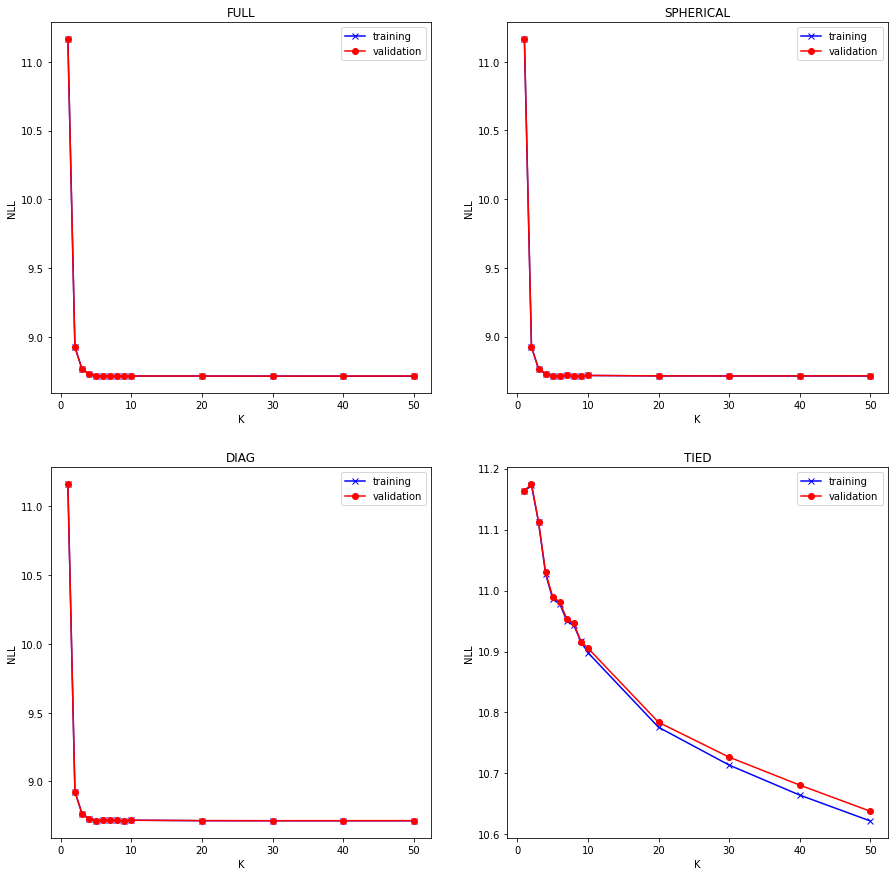

In [12]:
#Create elbow plot

fig,ax = plt.subplots(2, 2, figsize=(15,15))


for i, cov_type in enumerate(hyperparams["cov_types"]):
    row_num = int(i/2)
    col_num = i%2
    if len(ax.shape) > 1:
        line1 = ax[row_num, col_num].plot(hyperparams['nvals'], _trainNLL[(0 + (i * 14)):(14 + (i * 14))], 'bx-')
        line2 = ax[row_num, col_num].plot(hyperparams['nvals'], _validNLL[(0 + (i * 14)):(14 + (i * 14))], 'ro-')
        ax[row_num, col_num].set_xlabel('K')
        ax[row_num, col_num].set_ylabel('NLL')
        ax[row_num, col_num].title.set_text(cov_type.upper())
        ax[row_num, col_num].legend(['training', 'validation'])
    else:
        line1 = ax[col_num].plot(hyperparams['nvals'], _trainNLL[(0 + (i * 14)):(14 + (i * 14))], 'bx-')
        line2 = ax[col_num].plot(hyperparams['nvals'], _validNLL[(0 + (i * 14)):(14 + (i * 14))], 'ro-')
        ax[col_num].set_xlabel('K')
        ax[col_num].set_ylabel('NLL')
        ax[col_num].title.set_text(cov_type.upper())
        ax[col_num].legend(['training', 'validation'])


Text(0.5, 1.0, 'Elbow Method For Optimal n')

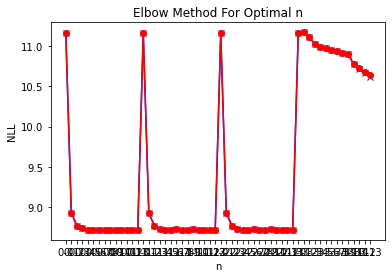

In [14]:
plt.figure(0)
plt.plot(_nvalid, _trainNLL, 'bx-')
plt.plot(_nvalid, _validNLL, 'ro-')
plt.xlabel('n')
plt.ylabel('NLL')
plt.title('Elbow Method For Optimal n')

In [21]:
hyperparams = dict(max_iters=[10, 100, 1000, 10000, 100000],
                   reg_covars=[1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1],
                   nvals=(1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 20, 30, 40 , 50),
                   cov_types=['full', 'spherical', 'diag', 'tied'])

min_nll_index = _validNLL.index(min(_validNLL))
_hyperparams = _nvalid[min_nll_index].split('-')
cov_type = hyperparams['cov_types'][int(_hyperparams[0])]
components = hyperparams['nvals'][int(_hyperparams[1])]
print(cov_type, components)

spherical 9


In [23]:
model = GaussianMixture(n_components=components, covariance_type=cov_type, random_state = rs, max_iter=_valid_max_iter, reg_covar=_valid_reg_covar)
model.fit(X)
print(X.shape)
Xn = model.sample(382154)


(382154, 1)


In [24]:
model.converged_

True

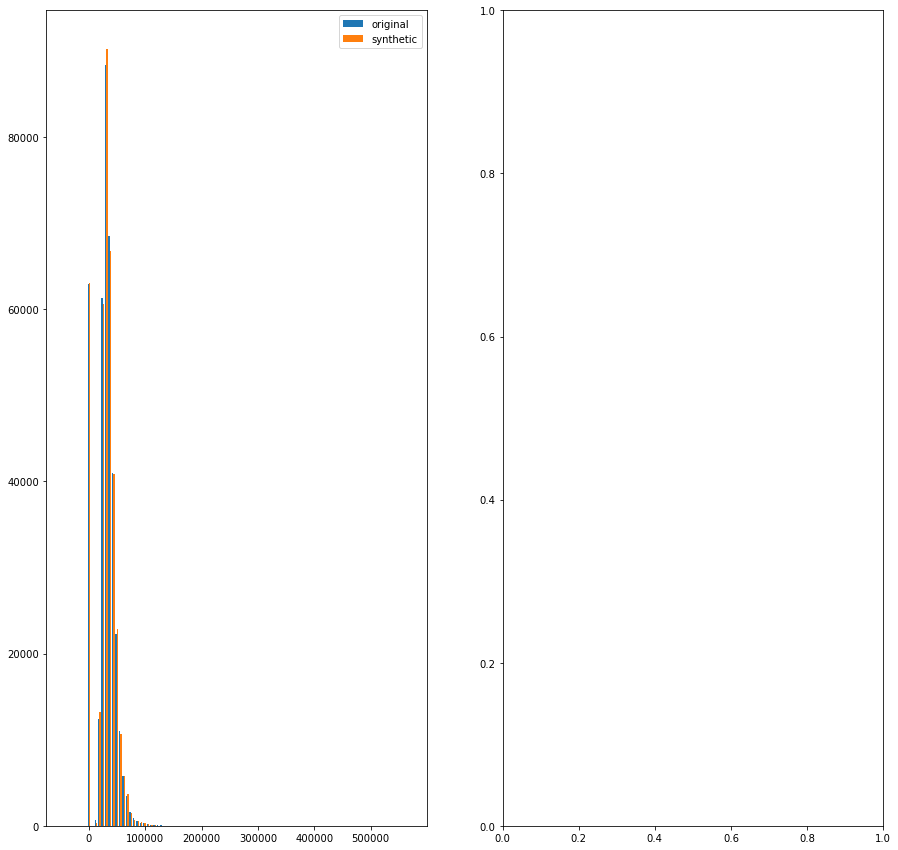

In [25]:
# plotting the distribution of the features using histogram
n_features = X.shape[1]
fig_rows = int(n_features/2) if n_features % 2 == 0 else int(n_features/2 + 1)
fig_columns = 2
bins = 100

fig,ax = plt.subplots(fig_rows, fig_columns, figsize=(15,15))
for feature in range(n_features):
    row_num = int(feature/fig_columns)
    col_num = feature%fig_columns
    if len(ax.shape) > 1:
        ax[row_num, col_num].hist([X[:, feature], Xn[0][:, feature]],
                                  bins=bins,
                                  label=['original', 'synthetic'])
        ax[row_num, col_num].legend(['original', 'synthetic'])

    else:
        ax[col_num].hist([X[:, feature], Xn[0][:, feature]],
                         bins=bins, 
                         label=['original', 'synthetic'])
        ax[col_num].legend(['original', 'synthetic'])


In [26]:
from scipy.stats import ks_2samp

n_samples, n_features = X.shape

for col in range(n_features):
    pvalue = ks_2samp(data1=X[:, col], data2=Xn[0][:, col], alternative='two-sided')
    print(pvalue)

KstestResult(statistic=0.08245105376366596, pvalue=0.0)


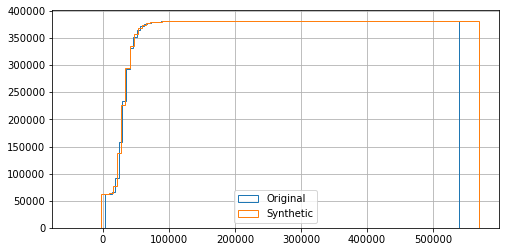

In [27]:
fig, ax = plt.subplots(figsize=(8, 4))

n0, bins0, patches0 = ax.hist(X[:, 0],
                              bins=100,
                              histtype='step',
                              cumulative=True,
                              label='Original')
n1, bins1, patches1 = ax.hist(Xn[0][:, 0],
                              bins=bins,
                              histtype='step',
                              cumulative=True,
                              label='Synthetic')
ax.grid(True)
ax.legend(loc='lower center')